In [1]:
import pandas as pd
import spacy
import networkx as nx
from itertools import combinations
from collections import defaultdict
import operator
import matplotlib.pyplot as plt
import numpy as np
# from math import log

In [2]:
def coocurrence(*inputs):
    com = defaultdict(int)
    
    for named_entities in inputs:
        # Build co-occurrence matrix
        for w1, w2 in combinations(sorted(named_entities), 2):
            com[w1, w2] += 1
            com[w2, w1] += 1  #Including both directions

    result = defaultdict(dict)
    for (w1, w2), count in com.items():
        if w1 != w2:
            result[w1][w2] = {'weight': count}
    return result

In [3]:
# Example coocurrence.
# Originally d is not a key here (since included in previous coocurrences)
# Altered to include ALL now, seems to make difference for my methodology below

coocurrence('abcddc', 'bddad', 'cdda')

defaultdict(dict,
            {'a': {'b': {'weight': 2}, 'c': {'weight': 3}, 'd': {'weight': 7}},
             'b': {'a': {'weight': 2}, 'c': {'weight': 2}, 'd': {'weight': 5}},
             'c': {'a': {'weight': 3}, 'b': {'weight': 2}, 'd': {'weight': 6}},
             'd': {'a': {'weight': 7},
              'b': {'weight': 5},
              'c': {'weight': 6}}})

In [4]:
# check out the data
data = pd.read_csv('../input/snopes.csv')
data.head(2)

,snopes_page,topic,claim,claim_label,date_published,date_updated,page_url,page_is_example,page_is_image_credit,page_is_archived,page_is_first_citation,tags
0,http://www.snopes.com/georgia-bans-muslim-cult...,politics,Georgia recently became the first U.S. state t...,false,"Nov 17th, 2016","Mar 20th, 2017",http://www.legis.ga.gov/Legislation/en-US/disp...,False,False,False,True,NaN
1,http://www.snopes.com/georgia-bans-muslim-cult...,politics,Georgia recently became the first U.S. state t...,false,"Nov 17th, 2016","Mar 20th, 2017",http://arabsinamerica.unc.edu/identity/veiling...,False,False,False,False,NaN


In [5]:
# Could keep in dataframe format? 
# Can make use of other fields for analysis/graph, since not a huge dataset

In [6]:
# drop duplicate claims (and unneccesary columns?)
data.drop_duplicates(subset='claim', inplace=True)

# remove 'examples' (Some odd artifacts that messed with analysis)
data = data.replace({'Example\(s\)': ''}, regex=True)
data = data.replace({'\s+': ' '}, regex=True)

In [7]:
# remove duplicate claims (Not really needed since dropped already)
claims = data.claim.unique()

# make sure it's all strings 
# added lower and whitespace strip just in case
# claims = [str(claim).lower().strip() for claim in claims]
# Turns out this ruins it... and reduced most docs to few claims for some reason

# NER list we'll use - Perhaps could be expanded?
nlp = spacy.load('en_core_web_sm')

# intialize claim counter & lists for our entities
coocur_edges = {}

print('Number of claims: ', len(claims))

Number of claims:  3122


In [8]:
# Lets look at the first few claims, along with the ents identified

for doc in nlp.pipe(claims[:5]):
    print(doc)
    print(list(doc.ents))
    print('\n')

Georgia recently became the first U.S. state to "ban Muslim culture."
[Georgia, first, U.S., Muslim]


An Image depicts a fatal collision involving a Chevy Suburban that recklessly merged ahead of a tractor-trailer, resulting in the death of an infant. See 
[Chevy, Suburban]


A special property of the equinox allows eggs (or brooms) to be balanced on their ends that day. See 
[that day]


Sophia Stewart won a large judgment in a copyright infringement suit over authorship of the film The Matrix. See 
[Sophia Stewart, Matrix]


Images show several large topiary cats created by a retiree and artist named John Brooker.
[John Brooker]




In [9]:
# Separating this lengthy step, and saving result as a list rather than generator
# (Size isnt too big, and saves a lot of time when reused later)

# Spacy seems to have error at 3k doc mark? 
# Related to this maybe? https://github.com/explosion/spaCy/issues/1927
# Continuing on with the first 3000 of 3122 for now

corpus = list(nlp.pipe(claims[:3000]))

In [10]:
# Looking at number of times each ent appears in the total corpus
# nb. ents all appear as Spacy tokens, hence needing to cast as str

all_ents = defaultdict(int)

for i, doc in enumerate(corpus):
    #print(i,doc)
    for ent in doc.ents:
        all_ents[str(ent)] += 1
        
print('Number of distinct entities: ', len(all_ents))

Number of distinct entities:  2730


In [11]:
# Most popular ents

sorted_ents = sorted(all_ents.items(), key=operator.itemgetter(1), reverse=True)
sorted_ents[:20]

[('Donald Trump', 302),
 ('Hillary Clinton', 178),
 ('Obama', 145),
 ('U.S.', 94),
 ('2016', 74),
 ('Trump', 65),
 ('Muslim', 58),
 ('Bernie Sanders', 49),
 ('Facebook', 47),
 ("Donald Trump's", 46),
 ('the United States', 45),
 ('first', 37),
 ('two', 37),
 ('Republican', 37),
 ('Muslims', 36),
 ('American', 35),
 ('Americans', 33),
 ('Photograph', 31),
 ('America', 30),
 ('Russian', 29)]

In [12]:
# Number of ents that appear at least twice

multi_ents = [x for x in sorted_ents if x[1] > 1]

print('Number of ents that appear at least twice: ', len(multi_ents))

Number of ents that appear at least twice:  681


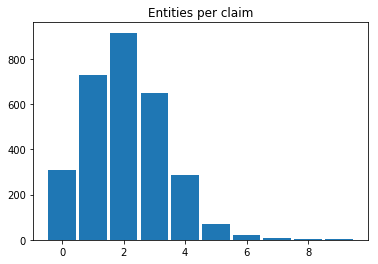

In [13]:
# How many ents appear per claim?

ents_in_claim = [len(doc.ents) for doc in corpus]

plt.hist(ents_in_claim, 
         rwidth=0.9, 
         bins=np.arange(max(ents_in_claim)+2)-0.5)  
        # Futzing with bins just to fix column alignment - not really necessary
plt.title('Entities per claim')
plt.show()

In [14]:
# Listing claims as a list of their entities

claim_ents = []
for i, doc in enumerate(nlp.pipe(claims[:5])):
    string_ents = list(map(str, doc.ents))
    claim_ents.append(string_ents)
    # Doubling some up to fake/force coocurrence
    if i%2==0:
        claim_ents.append(string_ents)  
claim_ents

# Could do as a one line list comprehension, though maybe not as readable:
# claim_ents = [list(map(str, doc.ents)) for doc in nlp.pipe(claims[:10]*2)]

[['Georgia', 'first', 'U.S.', 'Muslim'],
 ['Georgia', 'first', 'U.S.', 'Muslim'],
 ['Chevy', 'Suburban'],
 ['that day'],
 ['that day'],
 ['Sophia Stewart', 'Matrix'],
 ['John Brooker'],
 ['John Brooker']]

In [15]:
# Can filter out claims with only 1 ent (nothing to coocur with)

multi_ent_claims = [c for c in claim_ents if len(c)>1]
# single_ent_claims = [c for c in claim_ents if len(c)==1]
# no_ent_claims = [c for c in claim_ents if len(c)==0]

multi_ent_claims

[['Georgia', 'first', 'U.S.', 'Muslim'],
 ['Georgia', 'first', 'U.S.', 'Muslim'],
 ['Chevy', 'Suburban'],
 ['Sophia Stewart', 'Matrix']]

In [16]:
# Generating coocurrence dict of dicts

coocur_edges = coocurrence(*multi_ent_claims)
coocur_edges

defaultdict(dict,
            {'Georgia': {'Muslim': {'weight': 2},
              'U.S.': {'weight': 2},
              'first': {'weight': 2}},
             'Muslim': {'Georgia': {'weight': 2},
              'U.S.': {'weight': 2},
              'first': {'weight': 2}},
             'U.S.': {'Georgia': {'weight': 2},
              'Muslim': {'weight': 2},
              'first': {'weight': 2}},
             'first': {'Georgia': {'weight': 2},
              'Muslim': {'weight': 2},
              'U.S.': {'weight': 2}},
             'Chevy': {'Suburban': {'weight': 1}},
             'Suburban': {'Chevy': {'weight': 1}},
             'Matrix': {'Sophia Stewart': {'weight': 1}},
             'Sophia Stewart': {'Matrix': {'weight': 1}}})

In [17]:
# Filter out ents with <2 weight - refactored into a function later.
# (Could also use: del coocur_edges[k1][k2] rather than make new dict)

coocur_edges_filtered = defaultdict()

for k1, e in coocur_edges.items():
    ents_over_2_weight = {k2: v for k2, v in e.items() if v['weight'] >= 1}
    if ents_over_2_weight:  # ie. Not empty
        coocur_edges_filtered[k1] = ents_over_2_weight

coocur_edges_filtered

defaultdict(None,
            {'Georgia': {'Muslim': {'weight': 2},
              'U.S.': {'weight': 2},
              'first': {'weight': 2}},
             'Muslim': {'Georgia': {'weight': 2},
              'U.S.': {'weight': 2},
              'first': {'weight': 2}},
             'U.S.': {'Georgia': {'weight': 2},
              'Muslim': {'weight': 2},
              'first': {'weight': 2}},
             'first': {'Georgia': {'weight': 2},
              'Muslim': {'weight': 2},
              'U.S.': {'weight': 2}},
             'Chevy': {'Suburban': {'weight': 1}},
             'Suburban': {'Chevy': {'weight': 1}},
             'Matrix': {'Sophia Stewart': {'weight': 1}},
             'Sophia Stewart': {'Matrix': {'weight': 1}}})

In [18]:
# Summing all coocurrences in order to see most coocurring edges

coocur_sum = defaultdict(int)
for k1, e in coocur_edges_filtered.items():
    for k2, v in e.items():
        coocur_sum[k1] += v['weight']

sorted_coocur = sorted(coocur_sum.items(), key=operator.itemgetter(1), reverse=True)
sorted_coocur

[('Georgia', 6),
 ('Muslim', 6),
 ('U.S.', 6),
 ('first', 6),
 ('Chevy', 1),
 ('Suburban', 1),
 ('Matrix', 1),
 ('Sophia Stewart', 1)]

In [19]:
# Making the list of claims
claim_ents = []
for doc in corpus:
    string_ents = list(map(str, doc.ents))
    claim_ents.append(string_ents)
    
    
# Keeping only claims with multiple entities
multi_ent_claims = [c for c in claim_ents if len(c)>1]
# single_ent_claims = [c for c in claim_ents if len(c)==1]
# no_ent_claims = [c for c in claim_ents if len(c)==0]


# Creating the coocurrance dict
coocur_edges = coocurrence(*multi_ent_claims)

In [20]:
# Filter out ents with < min_weight - useful for graph clarity?

def filter_ents_by_min_weight(edges, min_weight):
    coocur_edges_filtered = defaultdict()
    for k1, e in edges.items():
        ents_over_x_weight = {k2: v for k2, v in e.items() if v['weight'] > min_weight}
        if ents_over_x_weight:  # ie. Not empty
            coocur_edges_filtered[k1] = ents_over_x_weight
    return coocur_edges_filtered

In [21]:
# Looking at the most coocurring edges

filtered_edges = filter_ents_by_min_weight(coocur_edges, 2)

coocur_sum = defaultdict(int)
for k1, e in filtered_edges.items():
    for k2, v in e.items():
        coocur_sum[k1] += v['weight']

sorted_coocur = sorted(coocur_sum.items(), key=operator.itemgetter(1), reverse=True)
print('Most frequent CO-ocurring entity:')
sorted_coocur[:20]

Most frequent CO-ocurring entity:


[('Donald Trump', 169),
 ('Hillary Clinton', 107),
 ('Obama', 80),
 ('U.S.', 47),
 ('2016', 47),
 ('Republican', 24),
 ('first', 23),
 ('Trump', 22),
 ('American', 22),
 ('Bernie Sanders', 20),
 ('Muslims', 19),
 ('Russian', 16),
 ('Democratic', 16),
 ('Barack Obama', 15),
 ('Vladimir Putin', 15),
 ('Muslim', 14),
 ('Americans', 14),
 ('Washington', 12),
 ('Mike Pence', 11),
 ('Supreme Court', 11)]